# Ising model

Here we consider inference on an Ising model.
First we import the code and set some plotting parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

## 1D model

The one dimensional Ising model considers a target distribution $\pi(x)$
on $\mathcal{X}=\{-1,1\}^M$ such that
$$
    \pi(x)\propto\exp\left\{\sum_{m=1}^{M-1} x_m x_{m+1}\right\}.
$$
The normalizing constant is intractable since it involves a sum over $2^M$ terms
but the full conditionals $\pi_m$ can be calculated in closed form.
Specifically, for the particles $x_1$ and $x_M$ the full conditional
only depends on their only neighbors:
$$
    \pi_1(x)=\frac{\exp(x x_2)}{2\cosh(1)},\qquad
    \pi_M(x)=\frac{\exp(x x_{M-1})}{2\cosh(1)}.
$$
The normalizing constant is tractable since it involves adding over two terms only
and can be simplified since $\cosh(1)=\cosh(-1)$.
The probability for particles with two neighbors 
$x_m,  m\neq1,M$ is likewise given by
$$
    \pi_m(x)=\frac{\exp(x x_{m-1} + x x_{m+1})}{2\cosh(x_{m-1}+x_{m+1})}.
$$

We consider an instantiation with $M=5$ particles
that starts at a uniform distribution over the $2^M$ possible arrangements.

In [2]:
#######################
#######################
# model specification #
#######################
#######################
M=5 # number of particles

# data
y_obs=np.ones(M)
y_obs[-1]=0

# likelihood
def ll(x,y):
    out = np.log(0.5)*np.ones()
    return 0.

# target
logZ1=np.log(2*np.cosh(1)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(xc[axis-1,:]+xc[axis+1,:]))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [3]:
lq0 = lambda x,u : -M*np.log(2)*np.ones(x.shape[1])
def randq0(size): 
    tmpx=np.random.randint(low=0,high=2,size=(M,size))
    return tmpx,np.random.rand(M,size)

In [4]:
xsamples,usamples=randqN(1000,N=50,lp=lp,randq0=randq0,xi=np.pi/16)

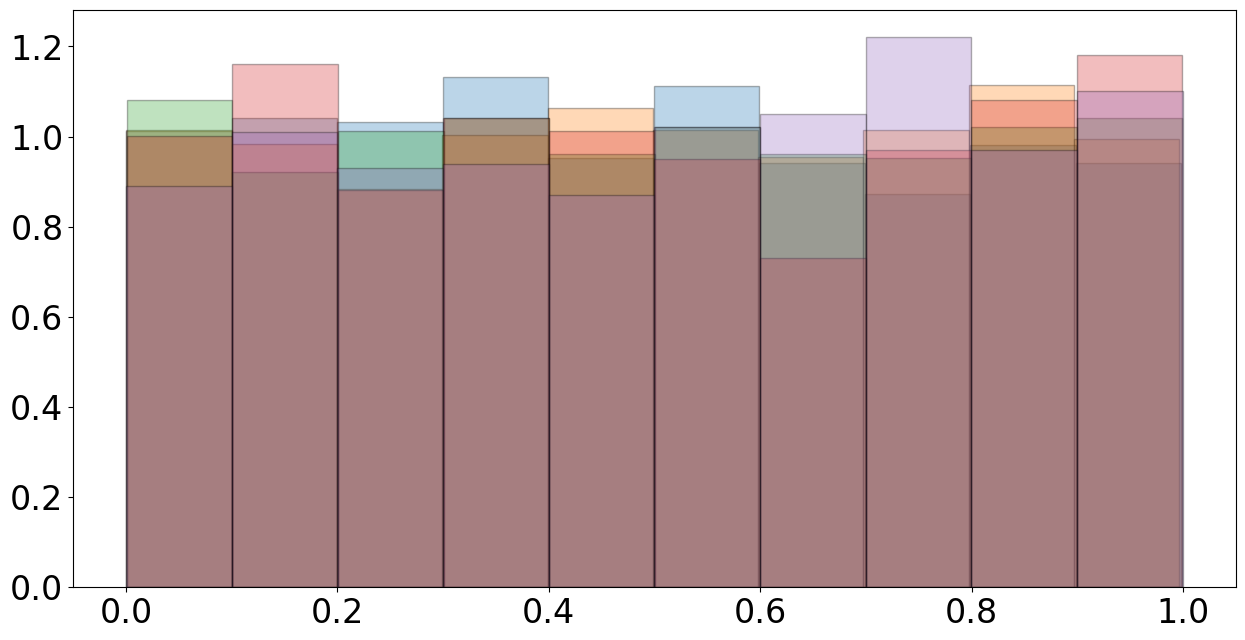

In [5]:
for m in range(usamples.shape[0]): plt.hist(usamples[m,:],density=True,alpha=0.3,ec='black',bins=10)

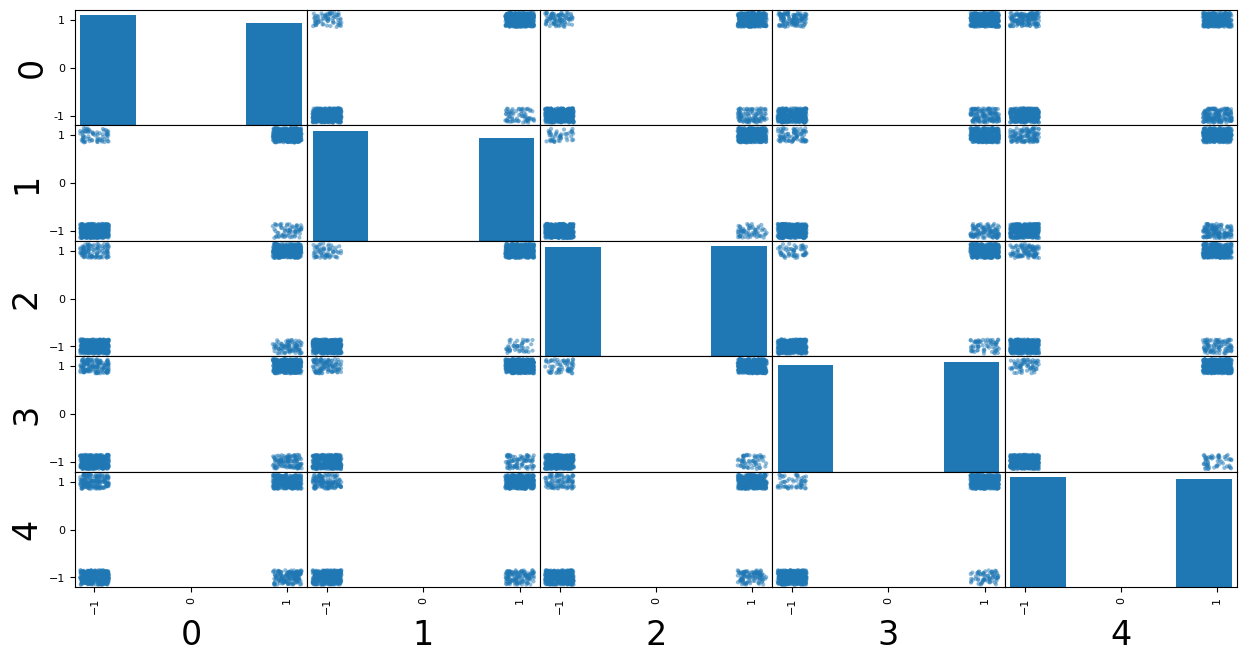

In [6]:
jit=0.3 # to jitter scatterplot
xcsamples=2.*xsamples-1. # to transform back to -1,1
for m in range(M): xcsamples[m,:]=xcsamples[m,:]+jit*np.random.rand(xcsamples.shape[1])-0.5*jit
df = pd.DataFrame(xcsamples.T)
axes = pd.plotting.scatter_matrix(df, alpha=0.5,hist_kwds={'bins': 4})